# Analysis of Monthly Mean Historical Meteorologic Variables from LOCA and BCSD

This notebook analyzes meteorologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective gridded observations used for training -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Precipitation
- Temperature

In [1]:
from loca import print_date
print_date()

Last executed: 2019-10-04 12:56:02.662357 by jvano on casper20


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import cmocean

import xarray as xr

from loca.data_catalog import load_monthly_historical_met_datasets, load_daily_livneh_meteorology, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION, add_ylabel
from cmocean import cm

# models currently using:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1'] 

# list of 23:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
#           'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

models = ['ACCESS1-0', 'CanESM2', 'MIROC5']

#cache is written in script "write_cache.ipynb"  TODO
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

met_vars = ['pcp', 't_mean']

#cache is written in script write_cache
read_cache = True

In [3]:
from dask.distributed import Client
# client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.226:38451 Dashboard: proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 60.00 GB


# Load Data

In [4]:
hist_cmip_met_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_met_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_met_data['loca']
    print(ds['pcp'])
    #TODO once get obs load separate won't have to do work around below (see Fig 16 script)
    single = ['ACCESS1-0']
    obs_data = load_monthly_historical_met_datasets(models=single, autoclose=True, parallel=True)
    print("finished reading obs")

else:
    print("reading values from files directly")
    met_data = load_monthly_historical_met_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache
<xarray.DataArray 'pcp' (gcm: 23, time: 672, lat: 224, lon: 464)>
dask.array<shape=(23, 672, 224, 464), dtype=float64, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CESM1-BGC' ... 'bcc-csm1-1' 'inmcm4'
load_monthly_historical_met_datasets
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_livneh_meteorology
load_daily_livneh_meteorology
load_monthly_maurer_meteorology
load_daily_maurer_meteorology
finished reading obs


In [5]:
# merging
met_data = {**obs_data, **hist_cmip_met_data}

#list(met_data.keys())
#print(met_data)

In [7]:
# hist_cmip_met_data['bcsd']
# hist_cmip_met_data['bcsd']['pcp'].isel(gcm=0, time=0).plot()

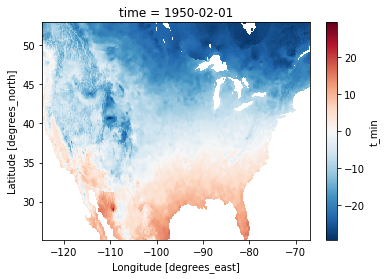

In [6]:
met_data['maurer']['t_min'].isel(time=1).plot()
# met_data['maurer']['pcp'].isel(time=1).plot()

In [7]:
epoch = slice('1970-01-01', '1999-12-31') # updated to be water year
print("finished slice")

mask = met_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS',
                                             chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in met_data.items())
print("finished epoch_means")
ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_met_data.items())
print("finished ens_means")

# for debugging
# epoch_means = {}
# for k, ds in met_data.items():
#     print(k, flush=True)
#     epoch_means[k] = ds.sel(time=epoch).mean('time').where(mask).compute()

finished slice
finished epoch_means
finished ens_means


In [10]:
# met_vars = 't_mean'
# variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}
# title = variablename[met_vars]
# display (title)

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values 
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations

In [ ]:
# FIG 4 and 5 (when pct = False) and appendix A Fig A2b (when pct = True)

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'
style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1'] 
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5'] 

variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}


kwargs = {'pcp': {'vmin': 0, 'vmax': 2500, 'cmap': watercmap, **style_kwargs},
          't_mean': {'vmin': -10, 'vmax': 20, 'extend': 'both', **style_kwargs},}
units = {'pcp': 'mm', 't_mean': 'C'}

diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}, 
                    't_mean': {'vmin': -1, 'vmax': 1, 'cmap': tempcmapdiff,  'extend': 'both', **style_kwargs}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}}}

nrows = 1 + len(models)
ncols = 2

met_vars = ['pcp', 't_mean']
# met_vars = ['pcp']


for var in met_vars:
    
    for pct in [True]:
#     for pct in [True, False]:
  
        if var not in diff_kws[pct]:
            continue
    
#         fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 2*nrows))
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})

        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var]) 
#             obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

            if col == 0:
#                 ax.set_ylabel('OBS')
                add_ylabel(ax, 'OBS', fontsize=16)

            ax.set_title(title, fontsize=16)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
#                 diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[pct][var]) 

                if col == 0:
#                     ax.set_ylabel(model)
                    add_ylabel(ax, model, fontsize=16)

        ax = axes[0, -1]
        diff = calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct)
#         .plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        make_plot(diff, ax=ax, plot_kwargs=diff_kws[pct][var])
#         ax.set_title('LOCA - BCSD')  
        axes[0, -1].set_title('LOCA - BCSD', fontsize=16)

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]  
#             diff.sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
            make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[pct][var]) 

        title = variablename[var]
#         title = var.upper()
#         title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=24, y=1.02)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_mon_hist_met.png', dpi=300, bbox_inches='tight')

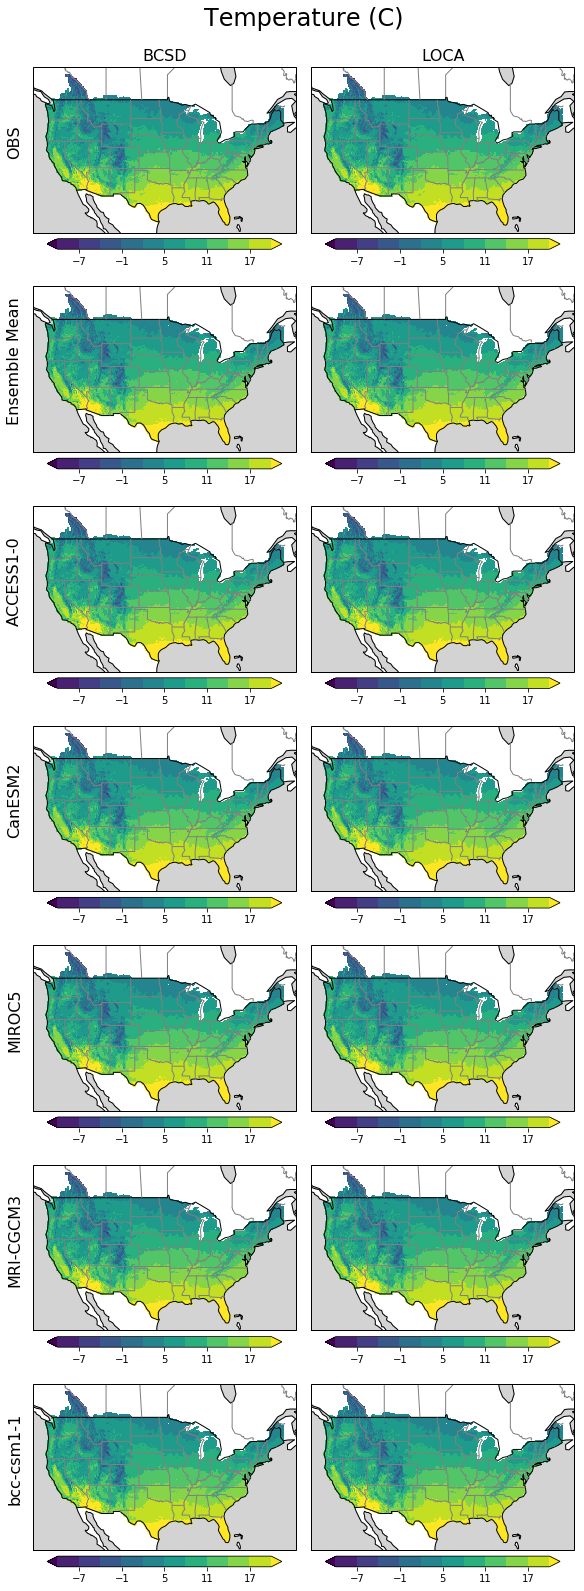

In [14]:
# TOTAL MAGNITUDE, APPENDIX A

watercmap = cm.rain  #https://matplotlib.org/cmocean/

variablename = {'t_mean': 'Temperature (C)', 'pcp': 'Precipitation (mm)'}
met_vars = 't_mean'
variablename[met_vars]

style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

kwargs = {'pcp': {'vmin': 0, 'vmax': 2500, 'cmap': watercmap, **style_kwargs},
          't_mean': {'vmin': -10, 'vmax': 20, 'extend': 'both', **style_kwargs},}

units = {'pcp': 'mm', 't_mean': 'C'}

models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1']

nrows = 2 + len(models)
ncols = 2

# met_vars = ['t_mean', 'pcp']
met_vars = ['t_mean']
for var in met_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 3.1*nrows),subplot_kw={'projection': PROJECTION})
    
    for col, (title, obs_data, ensemble, ds_data) in enumerate([('BCSD', epoch_means['maurer'], ens_means['bcsd'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], ens_means['loca'], epoch_means['loca'])]):
        
        ax = axes[0, col]
#         obs_data[var].plot.pcolormesh(ax=ax, **kwargs[var])
        make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var])  
#         make_plot(obs_data, ax=ax, plot_kwargs=diff_kws[pct][var])
        ax.set_title(title, fontsize=16)
        
        if col == 0:
#             ax.set_ylabel('OBS')
            add_ylabel(ax, 'OBS', fontsize=16)
        
        ax = axes[1, col]
#         ensemble[var].plot.pcolormesh(ax=ax, **kwargs[var])
        make_plot(ensemble[var], ax=ax, plot_kwargs=kwargs[var]) 
        if col == 0:
#             ax.set_ylabel('Ensemble Mean', fontsize=16)
            add_ylabel(ax, 'Ensemble Mean', fontsize=16)
        
        for row, model in enumerate(models, 2):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, **kwargs[var])
            make_plot(ds_data[var].sel(gcm=model), ax=ax, plot_kwargs=kwargs[var])  
            
            if col == 0:
#                 ax.set_ylabel(model)
                add_ylabel(ax, model, fontsize=16)
                
#     title = var.upper()
    title = variablename[var]
#     title += ' (%s)' % units[var]
    unit_str = units[var]
#     unit_str = units[var]
    fig.suptitle(title, fontsize=24, y=1.02)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_monthly_historic_met_ens.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')